# Cats and Dogs CNN

**Description:** Classify cats and dogs with a simple Convolutional Network<br>
                 
**Dataset:** Kaggle Dogs vs Cats dataset originally from Microsoft <br>

Have a look at https://keras.io/guides/transfer_learning/

<a target="_blank" href="https://colab.research.google.com/github/nerealegui/DL-course/blob/assignment_4/08_CNN_Cats_and_Dogs-Transfer_Learning.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
%matplotlib inline
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # to avoid warning messages


import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras import Input
from tensorflow.keras.layers import ReLU, Dense, Softmax, Rescaling, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, Sequential
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import image_dataset_from_directory
import tensorflow as tf

import numpy as np

import sys
sys.stderr = open('err.txt', 'w')

#### **Directories**
Reads the Cats and Dogs dataset and loads in. Creating a PetImages folder with two subfolders Cat and Dog <bbr>
Don't repeat this step as with the files/folders created it may have some issues

In [ ]:
# Loading the dataset from microsoft cloud - do it only once
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!unzip -q kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  87.1M      0  0:00:09  0:00:09 --:--:--  112M


#### **Cleaning data**
Just for security we delete some photos that may have the header corrupted.

In [ ]:
num_skipped = 0
num_images = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)
        else:
            num_images += 1

print(f"Deleted {num_skipped} images.")
print(f"There are {num_images} clean images.")

Deleted 1590 images.
There are 23412 clean images.


#### **Preparing the data**

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


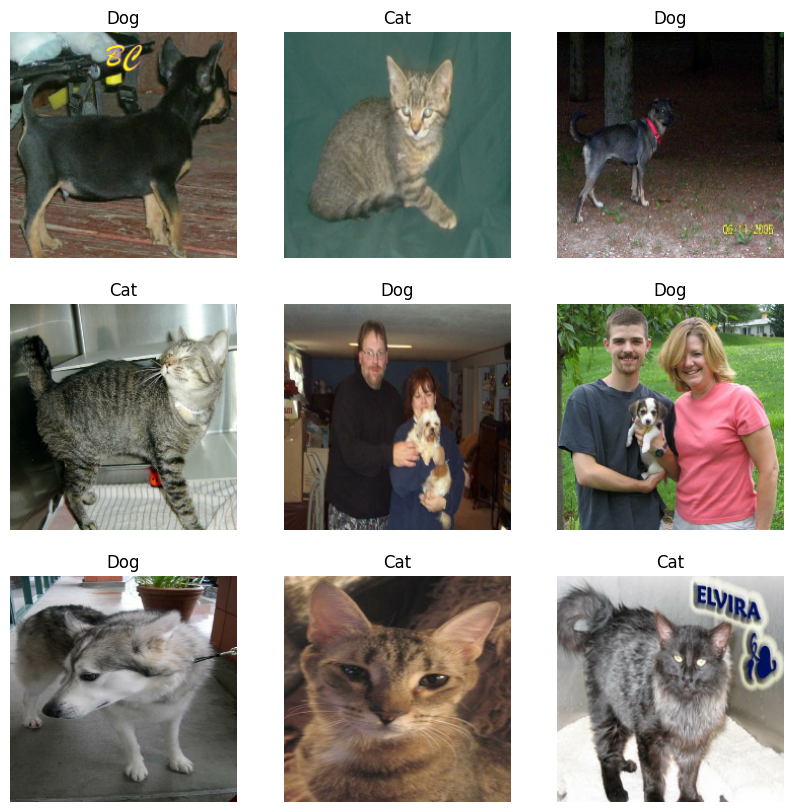

In [ ]:
batch_size = 32
img_height = 224
img_width  = 224
train_dir = './PetImages/'
class_names = ['Cat', 'Dog']

train_dataset = image_dataset_from_directory(
    train_dir,
    validation_split = 0.2,
    subset = 'training',
    label_mode = 'int',
    seed = 123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

validation_dataset = image_dataset_from_directory(
    train_dir,
    validation_split = 0.2,
    subset = 'validation',
    label_mode = 'int',
    seed = 123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Check images

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


# Optional: Normalize pixel values (0-255 to 0-1)
normalization_layer = Rescaling(1./255)

train_dataset        = train_dataset.map(lambda x, y: (normalization_layer(x), y))
validation_dataset   = validation_dataset.map(lambda x, y: (normalization_layer(x), y))

#### **Network Architecture Definition**

In [ ]:
from keras.applications.vgg19 import VGG19

base_model = VGG19(
    weights='imagenet',
    input_shape=(img_height, img_width, 3),
    include_top=False)

base_model.trainable = False

inputs = Input(shape=(img_height, img_width, 3))

x = base_model(inputs)

# New layers
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.1)(x)

#Output layer
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[inputs], outputs=output)

model.summary()
model.compile(loss='binary_crossentropy',
             optimizer = Adam(learning_rate=0.001), metrics=['acc'])

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg19 (Functional)                   │ (None, 7, 7, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,090,177 (76.64 MB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [ ]:
# training the network

In [ ]:
history = model.fit(
      train_dataset,
      epochs=5,
      validation_data=validation_dataset)


Epoch 1/5
586/586 ━━━━━━━━━━━━━━━━━━━━ 163s 257ms/step - acc: 0.8032 - loss: 0.4258 - val_acc: 0.8966 - val_loss: 0.2514
Epoch 2/5
586/586 ━━━━━━━━━━━━━━━━━━━━ 182s 241ms/step - acc: 0.8934 - loss: 0.2452 - val_acc: 0.9024 - val_loss: 0.2299
Epoch 3/5
586/586 ━━━━━━━━━━━━━━━━━━━━ 141s 241ms/step - acc: 0.9036 - loss: 0.2246 - val_acc: 0.9075 - val_loss: 0.2232
Epoch 4/5
586/586 ━━━━━━━━━━━━━━━━━━━━ 141s 241ms/step - acc: 0.9063 - loss: 0.2194 - val_acc: 0.9103 - val_loss: 0.2187
Epoch 5/5
586/586 ━━━━━━━━━━━━━━━━━━━━ 155s 263ms/step - acc: 0.9150 - loss: 0.2052 - val_acc: 0.8962 - val_loss: 0.2326


#### **Evaluate the Results**

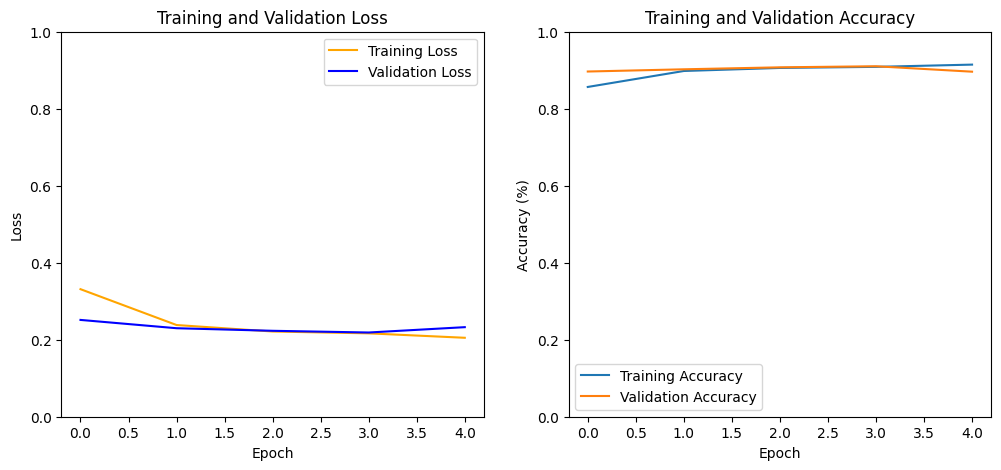

In [ ]:
# Plot training loss, accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='orange')
plt.plot(history.history['val_loss'], label='Validation Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.title('Training and Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.ylim(0,1)
plt.legend()
plt.show()


#### **Generate Confusion Matrix**

In [ ]:
# Generate predictions for the validation dataset
y_true = []
y_pred = []

for images, labels in validation_dataset:
    y_true.extend(labels.numpy())  # True labels
    preds = model.predict(images, verbose=0)  # Model predictions
    y_pred.extend((preds > 0.5).astype(int))

y_true = np.array(y_true)
y_pred = np.array(y_pred)


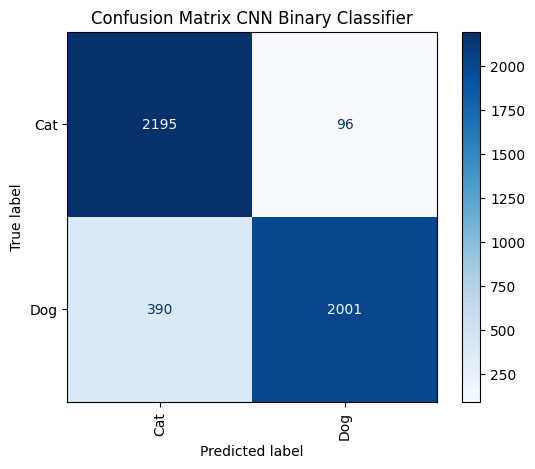

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
plt.title("Confusion Matrix CNN Binary Classifier")
plt.show()

In [ ]:
# Final accuracy
print('final accuracy test:', history.history['acc'][-1])
print('final accuracy validation', history.history['val_acc'][-1])

final accuracy test: 0.9145663976669312
final accuracy validation 0.8961982131004333


In [ ]:
#!pip install session-info

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 8.0 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8023 sha256=0f78589c4f8f76315e2ae3fa0ab3bcd61efe59db90581e4b93d1d9f818b4c7ea
  Stored in directory: /root/.cache/pip/wheels/4e/56/35/a748fc57279a4b84d0b332879445fed1ad8478e7257986b015
Successfully built session-info


In [ ]:
import session_info
session_info.show(html=False)

-----
keras               3.8.0
matplotlib          3.10.0
numpy               1.26.4
session_info        1.0.0
sklearn             1.6.1
tensorflow          2.18.0
-----
IPython             7.34.0
jupyter_client      6.1.12
jupyter_core        5.7.2
notebook            6.5.5
-----
Python 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
Linux-6.1.85+-x86_64-with-glibc2.35
-----
Session information updated at 2025-03-07 23:26


## Experiments

1. Use a Transfer learning approach with the cats and dogs dataset. See if you can beat your numbers
in Assignment 3
2. Use Transfer learning to do a Multi-class classifier with the Flowers dataset. How high can you get?

##  Questions to Answer

1. What is the precision that you obtained?
2. What are the implications of using Transfer Learning regarding training (is it faster, slower,...)?

## Experiment 1

In [ ]:
def plot_fine_tuning_results(history_fine):
    # Plot training loss, accuracy for fine-tuning
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history_fine.history['loss'], label='Training Loss', color='orange')
    plt.plot(history_fine.history['val_loss'], label='Validation Loss', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim(0,1)
    plt.title('Training and Validation Loss (Fine-tuning)')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history_fine.history['acc'], label='Training Accuracy')
    plt.plot(history_fine.history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy (Fine-tuning)')
    plt.ylim(0,1)
    plt.legend()
    plt.show()

    # Final accuracy
    print('final accuracy test:', history_fine.history['acc'][-1])
    print('final accuracy validation', history_fine.history['val_acc'][-1])


def evaluate_fine_tuning(model, validation_dataset, class_names):
    # Generate Confusion Matrix
    y_true_fine = []
    y_pred_fine = []
    for images, labels in validation_dataset:
        y_true_fine.extend(labels.numpy())  # True labels
        preds = model.predict(images, verbose=0)  # Model predictions
        y_pred_fine.extend((preds > 0.5).astype(int))
    y_true_fine = np.array(y_true_fine)
    y_pred_fine = np.array(y_pred_fine)

    # Compute confusion matrix
    cm_fine = confusion_matrix(y_true_fine, y_pred_fine)

    # Display confusion matrix
    disp_fine = ConfusionMatrixDisplay(confusion_matrix=cm_fine, display_labels=class_names)
    disp_fine.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
    plt.title("Confusion Matrix CNN Binary Classifier (Fine-tuning)")
    plt.show()

Epoch 1/5
586/586 ━━━━━━━━━━━━━━━━━━━━ 146s 244ms/step - acc: 0.9173 - loss: 0.1956 - val_acc: 0.9088 - val_loss: 0.2127
Epoch 2/5
586/586 ━━━━━━━━━━━━━━━━━━━━ 141s 241ms/step - acc: 0.9198 - loss: 0.1909 - val_acc: 0.9099 - val_loss: 0.2123
Epoch 3/5
586/586 ━━━━━━━━━━━━━━━━━━━━ 155s 263ms/step - acc: 0.9212 - loss: 0.1892 - val_acc: 0.9107 - val_loss: 0.2122
Epoch 4/5
586/586 ━━━━━━━━━━━━━━━━━━━━ 142s 242ms/step - acc: 0.9204 - loss: 0.1892 - val_acc: 0.9111 - val_loss: 0.2123
Epoch 5/5
586/586 ━━━━━━━━━━━━━━━━━━━━ 154s 263ms/step - acc: 0.9232 - loss: 0.1893 - val_acc: 0.9111 - val_loss: 0.2121


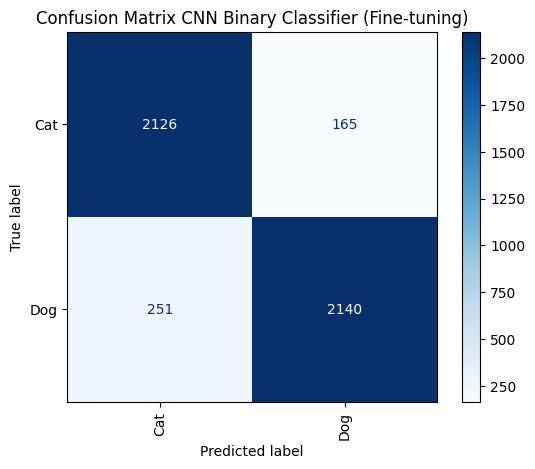

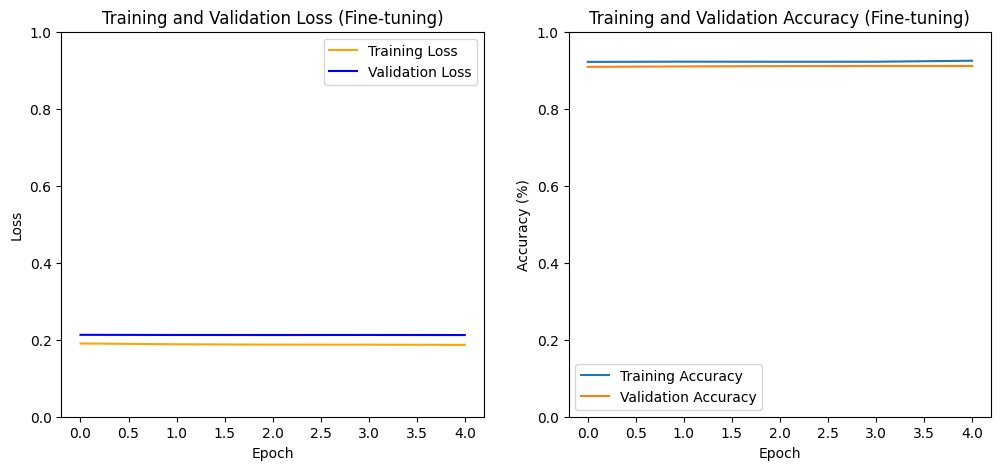

final accuracy test: 0.9246582388877869
final accuracy validation 0.9111490845680237


In [ ]:
%pip install keras

from keras.applications.vgg19 import VGG19

base_model = VGG19(
    weights='imagenet',
    input_shape=(img_height, img_width, 3),
    include_top=False)

base_model.trainable = False


# Freeze all layers except the last 10
for layer in base_model.layers[:-10]: # Freeze all but last 10 layers
    layer.trainable = False

# Recompile the model with a lower learning rate
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=1e-5),  # Lower learning rate
              metrics=['acc'])

# Fine-tune the model
history_fine = model.fit(
    train_dataset,
    epochs=5,
    validation_data=validation_dataset
)


# Call the function to evaluate fine-tuning
evaluate_fine_tuning(model, validation_dataset, class_names)

# Call the function to plot fine-tuning results
plot_fine_tuning_results(history_fine)

## Experiment 2

### Prep Data

Found 3670 files belonging to 1 classes.
Using 2936 files for training.
Found 3670 files belonging to 1 classes.
Using 734 files for validation.
Class names: ['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips']


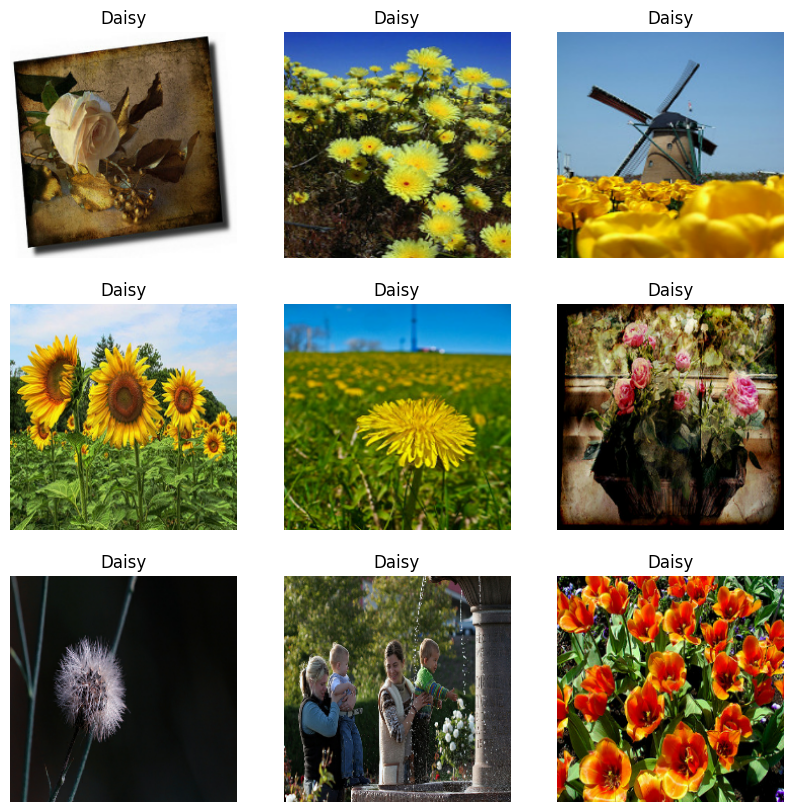

In [26]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, Rescaling
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Load the TensorFlow Flowers dataset
flowers_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
flowers_data_dir = tf.keras.utils.get_file('flower_photos', origin=flowers_dataset_url, untar=True)

# Prepare the data
batch_size = 32
img_height = 224
img_width = 224

class_names = ['Daisy','Dandelion','Roses','Sunflowers','Tulips']

train_dataset = image_dataset_from_directory(
    flowers_data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

validation_dataset = image_dataset_from_directory(
    flowers_data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

print("Class names:", class_names)

# Display some images with their labels
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()


# Normalize pixel values
normalization_layer = Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
validation_dataset = validation_dataset.map(lambda x, y: (normalization_layer(x), y))


### No transfer Learning

In [22]:
# Define the network architecture using a pre-trained model
base_model = VGG19(
    weights='imagenet',
    input_shape=(img_height, img_width, 3),
    include_top=False
)

base_model.trainable = False

inputs = Input(shape=(img_height, img_width, 3))
x = base_model(inputs)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.1)(x)
output = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=[inputs], outputs=output)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=1e-5),  # Lower learning rate
              metrics=['acc'])

# Train the model
history_fine = model.fit(
    train_dataset,
    epochs=5,
    validation_data=validation_dataset
)

# Call the function to evaluate fine-tuning
evaluate_fine_tuning(model, validation_dataset, class_names)

# Call the function to plot fine-tuning results
plot_fine_tuning_results(history_fine)



Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 29s 275ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/5


KeyboardInterrupt: 

### Transfer Learning

Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 33s 321ms/step - acc: 0.0000e+00 - loss: 0.3531 - val_acc: 0.0000e+00 - val_loss: 0.2564
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 32s 246ms/step - acc: 0.0000e+00 - loss: 0.2397 - val_acc: 0.0000e+00 - val_loss: 0.1781
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 249ms/step - acc: 0.0000e+00 - loss: 0.1692 - val_acc: 0.0000e+00 - val_loss: 0.1277
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 251ms/step - acc: 0.0000e+00 - loss: 0.1222 - val_acc: 0.0000e+00 - val_loss: 0.0938
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 23s 246ms/step - acc: 0.0000e+00 - loss: 0.0907 - val_acc: 0.0000e+00 - val_loss: 0.0709


ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of labels (1).

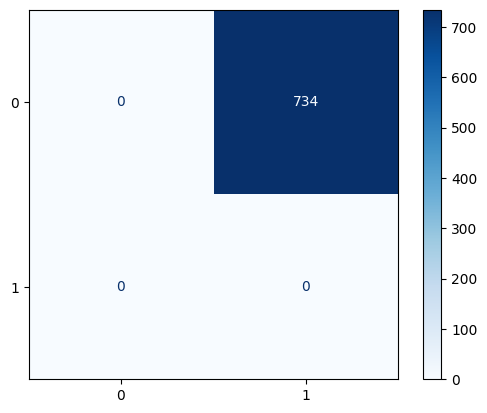

In [19]:
from keras.applications.vgg19 import VGG19

base_model = VGG19(
    weights='imagenet',
    input_shape=(img_height, img_width, 3),
    include_top=False)

base_model.trainable = False


# Freeze all layers except the last 10
for layer in base_model.layers[:-10]: # Freeze all but last 10 layers
    layer.trainable = False

# Recompile the model with a lower learning rate
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=1e-5),  # Lower learning rate
              metrics=['acc'])

# Fine-tune the model
history_fine = model.fit(
    train_dataset,
    epochs=5,
    validation_data=validation_dataset
)


# Call the function to evaluate fine-tuning
evaluate_fine_tuning(model, validation_dataset, class_names)

# Call the function to plot fine-tuning results
plot_fine_tuning_results(history_fine)